# TTT4275 Classification Project: Music Genre Classification

## Setup

In [49]:
# Imports
import source.data_handling
import source.mappings
import source.plotting
import source.diy_classifiers

import numpy as np

In [50]:
# Load the dataset and split into training and test
# X = M x N dataset with M samples of N features

data_version = source.data_handling.GENRE_CLASS_DATA_30S
data_frame = source.data_handling.read_genre_class_data(data_version)

features = source.mappings.MUSIC_FEATURES_ALL

training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_frame,
    features=features,
)

## Task 1

Using only the four features given in task 1a), we plot the confusion matrix and error rate for all genres.

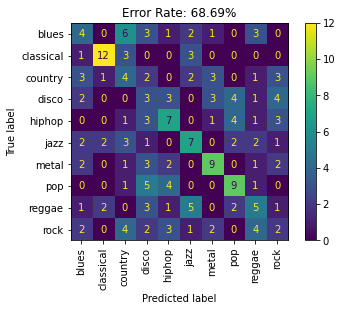

In [51]:
features_task_1 = ["spectral_rolloff_mean", "tempo", "spectral_centroid_mean", "mfcc_1_mean"]

training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_frame,
    features=features_task_1,
)

y_pred_task1 = source.diy_classifiers.kNN(k=5, train_data=training_data, test_data=test_data, p=2)
y_true_task1 = test_data.y

source.plotting.confusion_matrix(y_true_task1, y_pred_task1)

### KNN Parameters
Using all features we plot the error rates with respect to the number of neighbors and using different orders of the Minkowski order (p).
Once for our own implementation of the kNN classifier

In [ ]:
training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_frame,
)

ks = np.arange(20) + 1
ps = np.arange(10) + 1

source.plotting.error_rates_vs_params(ks, ps, training_data, test_data, diy=True)

And another time for the sklearn implementation

In [ ]:
training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_frame,
)

ks = np.arange(20) + 1
ps = np.arange(10) + 1

source.plotting.error_rates_vs_params(ks, ps, training_data, test_data, diy=False)

A larger number of neighbors to take into consideration could be beneficial when using KNN. Although the improvement is only small. Regarding the order of the Minkowski distance, interestingly the first order or Manhatten distance seems to perform the best and subsequent orders have worse error rates.
For both of these plots the improvement is not negligeable but small nonetheless.

## Task 2

In [ ]:
features_task_2 = ["spectral_rolloff_mean", "tempo", "spectral_centroid_mean", "mfcc_1_mean"]
genres_task_2 = ["pop", "disco", "metal", "classical"]

In [ ]:
source.plotting.feature_distribution_histogram(
    data_frame=data_frame,
    features=features_task_2,
    genres=genres_task_2,
)

As the tempo feature seems to have the largest overlap between the classes, we remove that feature and run the knn classifier from task 1 for all genres again.

In [ ]:
reduced_features_task_2 = ["spectral_rolloff_mean", "spectral_centroid_mean", "mfcc_1_mean"]

training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_frame,
    features=reduced_features_task_2,
)

y_pred_task1 = source.diy_classifiers.kNN(train_data=training_data, test_data=test_data, k=5, p=2)
y_true_task1 = test_data.y

source.plotting.confusion_matrix(y_true_task1, y_pred_task1)

For whatever reason removing the tempo does not seem to have a valueable impact on the error rate of the classifier.

Using only one of the features we run the classifier and for the four genres and take a look at the performance.

In [ ]:
for feature in features_task_2:
    training_data, test_data = source.data_handling.prepare_data(
        data_frame=data_frame,
        features=[feature],
        genres=genres_task_2,
    )

    y_pred_task1 = source.diy_classifiers.kNN(train_data=training_data, test_data=test_data, k=5, p=2)
    y_true_task1 = test_data.y
    
    print(f"{feature}")
    source.plotting.confusion_matrix(y_true_task1, y_pred_task1)

## Task 3

In [ ]:
# Crazy code

## Task 4

The current idea for our classifier design is to do three steps:
1. Scaling
2. Dimension Reduction
3. Classification

### Sklearn Pipelines
To figure out what could be the best approach for this, we'll do some exploratory work using sklearns pipelines to determine what has the largest impact on performance.

#### Scaling
There are a few different methods of scaling the input data. First and foremost the effect of having scaling versus not having scaling at all is taken into consideration.

In [ ]:
import sklearn.decomposition
import sklearn.neighbors
import sklearn.pipeline
import sklearn.preprocessing

In [ ]:
training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_frame,
)

pipelines = [
    sklearn.pipeline.Pipeline([
        ('classifier', sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, p=2)),
    ]),
    sklearn.pipeline.Pipeline([
        ('scaler', sklearn.preprocessing.MaxAbsScaler()),
        ('classifier', sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, p=2)),
    ]),
]

for pipeline in pipelines:
    pipeline.fit(training_data.x, training_data.y)
    predict_y = pipeline.predict(test_data.x)
    
    source.plotting.confusion_matrix(test_data.y, predict_y)

#### Dimension Reduction
Instead of having to run the classifier on all dimensions we can try to reduce the dimensions. For the KNN approach this will help with computing the distances once the dataset actually gets larger.
For now we can think of using:
- principle component analysis
- partial least squares discriminant analysis
- autoencoder

##### Principle Component Analysis

In [ ]:
training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_frame,
)

pca_pipelines = [
    ('KNN - all PCA components', sklearn.pipeline.Pipeline([
        ('scaler', sklearn.preprocessing.MaxAbsScaler()),
        ('reduce_dimension', sklearn.decomposition.PCA()),
        ('classifier', sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, p=2)),
    ])),
    ('KNN - 15 first PCA components',
    sklearn.pipeline.Pipeline([
        ('scaler', sklearn.preprocessing.MaxAbsScaler()),
        ('reduce_dimension', sklearn.decomposition.PCA(n_components=15)),
        ('classifier', sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, p=2)),
    ])),
    ('SVM - no PCA all features',
    sklearn.pipeline.Pipeline([
        ('scaler', sklearn.preprocessing.MaxAbsScaler()),
        ('classifier', sklearn.svm.SVC(kernel='rbf', decision_function_shape='ovo')),
    ])),
    ('SVM - all PCA components',
    sklearn.pipeline.Pipeline([
        ('scaler', sklearn.preprocessing.MaxAbsScaler()),
        ('reduce_dimension', sklearn.decomposition.PCA()),
        ('classifier', sklearn.svm.SVC(kernel='rbf', decision_function_shape='ovo')),
    ])),
    ('SVM - 15 first PCA components',
    sklearn.pipeline.Pipeline([
        ('scaler', sklearn.preprocessing.MaxAbsScaler()),
        ('reduce_dimension', sklearn.decomposition.PCA(n_components=15)),
        ('classifier', sklearn.svm.SVC(kernel='rbf', decision_function_shape='ovo')),
    ])),
]

for name, pipeline in pca_pipelines:
    print(name)
    pipeline.fit(training_data.x, training_data.y)
    predict_y = pipeline.predict(test_data.x)
    
    source.plotting.confusion_matrix(test_data.y, predict_y)

The observed results would imply that PCA does not positively affect the KNN classifier in anyway, but it could do so when using an SVM as the classifier method.

#### Classifier
So far we have only used the KNN classifier. Here we can also consider alternatives and the list to explore could look like:
- KNN
- Support Vector Machines
- Multi Layer Perceptron